In [1]:
# this code reads a list of sample coordiantes and values (e.g.  - log posterior evaluations) 
# and attempts a quadratic fit to predict location and value of the minimum
# minimization happens in convex subspace
# constraints "param_i > 0" are supported manually: hard constraints param_i = 0 can be added 
# This should only be done if miminum is otherwise violating the constraint, and one by one, in all permutations. 
# If needed, this could be automatized (or a different algorithm or library may be used)
# has been tested with converged markov chain data produced by Cobaya, for LCDM cosmology with Planck, BAO and Pantheon
# and similar cosmological models

# since the result is a guess, it is necessary to determine the true value (e.g. of the posterior) 

# the idea is to do a Taylor expansion to quadratic order around the best-fit sample, via a least-square fit to enough
# data points that are as close (in units of sigma obtained as sqrt(variance)) to that sample as possible. 
# Possible generalization would be to base this distance metric on the covariance matrix and not only the diagonal.
# Note that the final quadratic fit yields another covariance matrix, that is more accurate for local questions

# instead of fixing the fit to exactly hit the best-fit sample, we may allow add an additional 
# (it is worth to try out both options)

# andreas.finke@unige.ch for questions and comments 

allowOffset = True  

# path to data; will open all .txt files in folder 

directory = '/Users/.../chains/chain1/'

# number of parameters (exclude derived parameters!). Note: It is assumed the derived parameters come at the end,
# by taking the first nParams one and discarding the rest 

#nParams = 38 #MP
#nParams = 34 #Cob JLA
nParams = 28 #Cob Pant Pl18

# number of points to be used for the least-square fit - should scale like nParams^2 for a quadratic fit 

nGoal = 5*nParams**2


import numpy as np
import matplotlib.pyplot as plt
from os import listdir 


def list_files(directory, extension):
    return (f for f in listdir(directory) if f.endswith('.' + extension))

def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

filenames = list_files(directory, "txt")

y = np.empty((0)) 
x = np.empty((0,0))
first = True 


for filename in filenames:
    fp = open(directory + "/" + filename)
    lines = fp.readlines()

    data = [[float(v) for v in line.split()] for line in lines if all([isfloat(word) for word in line.split()]) ]
    data = np.array(data)
    y = np.concatenate((y, data[:,1]), axis=0)
    if first:
        x = data[:, 2:(nParams+2)]
        first = False 
    else:
        x = np.vstack((x, data[:, 2:(nParams+2)]))
    

[3.04739158e+00 9.67075671e-01 6.79201184e+01 2.24312615e-02
 1.19070290e-01 1.40222538e-02 5.66372070e-02 1.00078759e+00
 9.99680315e-01 9.98188791e-01 4.65906432e+01 5.29588353e-01
 5.45052064e+00 3.32697334e+00 8.92544598e+00 1.08553155e+01
 1.84944557e+01 9.36252705e+01 2.58818955e+02 4.60745138e+01
 4.27091512e+01 1.15764357e+02 1.14162092e-01 1.34367667e-01
 4.81599497e-01 2.23071638e-01 6.63154098e-01 2.07800495e+00]
[1.45721360e-02 3.65086124e-03 4.88496811e-01 1.32908446e-04
 9.07605693e-04 1.04785703e-02 7.39670623e-03 2.43231285e-03
 6.11304973e-04 6.19952445e-04 6.62071968e+00 2.81209930e-01
 1.94860040e+00 2.35076144e+00 1.83124000e+00 1.76618661e+00
 3.24569950e+00 7.25870353e+00 2.76068069e+01 7.75684040e+00
 9.08181786e+00 1.00895885e+01 3.84434241e-02 2.96473392e-02
 8.53123725e-02 5.38861838e-02 8.07417562e-02 2.67367143e-01]
1813
1823
1833
1842
1858
1864
1875
1884
1892
1901
1910
1919
1933
1941
1950
1964
1977
1988
1993
2010
2023
2031
2040
2050
2057
2063
2079
2092
2105

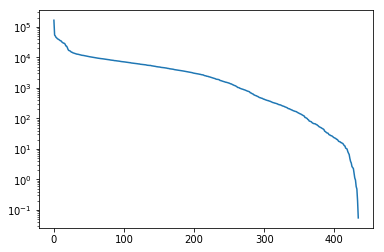

In [10]:

# starting guess for radius of ball 

R_ball = 4.2

y0 = y.min()
x0 = x[y.argmin(), :]


mean = np.mean(x, axis=0)

print(mean)

# sigma = np.mean((x-mean)**2,axis=0)**0.5

cov = (x-mean).T@(x-mean)/x.shape[0]
sigma = np.diag(cov)**0.5
#print(sigma**2 - np.diag(cov))

print(sigma)

xnormalized = (x-x0)/sigma

done = False

maxIters = 10000
iters = 0
while not done:
    
    closepointIndices = np.array(np.sum(xnormalized**2,axis=1) < R_ball**2)
    print(np.sum(closepointIndices))
    corr = (nGoal-np.sum(closepointIndices))
    
    iters += 1
    
    if abs(corr) < 3 or iters > maxIters:
        done = True
        
    
    R_ball = R_ball * (1 + corr/nGoal*1e-3)
    
    
    
# remove point of expansion
closepointIndices[y.argmin()] = False 

print(xnormalized[closepointIndices].shape[0])

xc = xnormalized[closepointIndices]
yc = y[closepointIndices]

xd = xc #- x0
yd = yc - y0


nDim = xd.shape[1] 

# default: no weights. 

weights = 1/(1+0*np.array(np.sum(xd**2,axis=1)))
W = np.diag(weights)

quadpart = np.matmul(xd[:,:,None], xd[:,None,:])


#double the offidagonals 
diagind  = np.arange(nDim)
quadpart[:, diagind, diagind] *= 0.5
quadpart *= 2 

#remove the symmetric half, make the triangular part a linear nDim(nDim-1) dimensional direction
trilind  = np.tril_indices(nDim)
quadpart = quadpart[:, trilind[0], trilind[1]]

offsetfac = 0.0
if allowOffset:
    offsetfac = 1.0
    
A  = np.concatenate((offsetfac*np.ones((xd.shape[0],1)), xd, quadpart), axis=1) 


Q,R = np.linalg.qr(A)

M = A.T@W@A 

u, s, vh = np.linalg.svd(M, full_matrices=False)
#uqr, sqr, vhqr = np.linalg.svd(R.T @ R, full_matrices=False)

#print(s)
#print(sqr)
plt.semilogy(s)
#plt.semilogy(sqr)


# deff = np.sum(s>1e-15)
# print(deff)

# sinv = np.zeros(s.shape)
# sinv[1:deff] = 1/s[1:deff]

# sinvqr = np.zeros(sqr.shape)
# sinvqr[1:deff] = 1/sqr[1:deff]


In [11]:
# most stable way I found to solve linear system 
sol3 = vh.conj().T@np.linalg.solve(np.diag(s), u.conj().T@A.T@W@yd)
#sol33 = vhqr.conj().T@np.linalg.solve(np.diag(sqr), uqr.conj().T@A.T@W@yd)

# but in this case once the system is well-defined this works as usual
import scipy as sp
#solQR = np.linalg.solve(R, Q.T@yd)
solQR = sp.linalg.solve_triangular(R, Q.T@yd)

In [21]:
#off = sol3[0]
off = solQR[0]



#grad3 = sol3[1:nDim+1]
grad3 = solQR[1:nDim+1]

hess3 = np.zeros((nDim, nDim))
#hess3[trilind] = sol3[nDim+1:]
hess3[trilind] = solQR[nDim+1:]

hess = np.copy(hess3)
grad = np.copy(grad3)
sol = np.copy(sol3)

print("Comparing the hessian/cov of likelihood with sigmas from sampled data")
print(np.diag(hess)*sigma**2)
print("Symmetrizity of hessian")
print(np.linalg.norm(hess-hess.T))
print("Norm of residual of system")
print(np.linalg.norm(M@sol-A.T@yd))

res = A@sol-yd

print("Mean residual of fit")
print(np.mean(res**2)**0.5)

SStot = np.sum((yd - np.mean(yd))**2)
print("R^2")
Rsq = 1-np.sum(res**2)/SStot
print(Rsq)

p = A.shape[1]
n = yd.shape[0]

print("Adjusted R^2")
print(1-(1-Rsq)*(n-1)/(n-p-1))

print("")


Comparing the hessian/cov of likelihood with sigmas from sampled data
[1.83915483e-02 3.32914028e-05 3.54516081e+00 3.35151944e-08
 8.79202805e-06 5.11612793e-04 4.83357700e-03 6.64184374e-05
 2.67898774e-07 3.41068343e-07 9.85627499e+02 6.10105854e-01
 2.48303548e+01 1.89812486e+01 2.09023751e+00 4.43257574e+00
 1.24965374e+02 8.78395179e+02 9.29255738e+02 2.21493423e+02
 1.25770451e+03 1.20187199e+03 9.03436139e-04 6.62215590e-04
 3.81669578e-03 2.15658217e-03 3.99836390e-03 4.27540564e-02]
Symmetrizity of hessian
166.68035059032294
Norm of residual of system
1.8015116999295234e-09
Mean residual of fit
0.30392878773147847
R^2
0.9851267904218232
Adjusted R^2
0.983268173309928



1.8015116999295234e-09

In [16]:
print(np.linalg.norm(hess-hess.T))

hesssym = (hess + hess.T)/2

evals, evecs = np.linalg.eig(hesssym)


#print(evals)
#print(evecs)

posD = np.sum(evals>0)

evecsPosSpace = evecs[:,evals>0]
evalsPosSpace = evals[evals>0]

print(posD)
gradPosSpace = evecsPosSpace.T @ grad

xdPosSpace = -0.5*gradPosSpace/evalsPosSpace

# here we can choose the parameters that should be positive. We do this buy forcing them to zero. 
# Usually we try to force none, but if some turn out negative and we don't want that, we force them to zero one by one. 
# In positive space, this is a nontrivial constraint of the form of selected elements of column vector (evecsPosSpace@xdPosSpace) being zero
# Let B be the matrix consisting of the selected rows corresponding to that column of evecsPosSpace
constraints = [13, 5]
B = evecsPosSpace[constraints, :]
# then B@xdPosSpace = -x0[constraints] is the constraint equations
# on the other hand, there is a lagrange multiplyer lamda for each constraint 
# (such that normal on constraint surface is parallel to gradient of unconstrained goal)
# we want to minimize the convex subpart of the quadratic goal, which is already diagonal: find xPosSpace s.t.
# xPosSpace@diag(evecsPosSpace)@xPosSpace + gradPosSpace@xPosSpace is minimal.
# Without constraints, xdPosSpace = -0.5*gradPosSpace/evalsPosSpace
# But with, 2*diag(evecsPosSpace)@xPosSpace + gradPosSpaced = B.T @ [lambda]
# So 
# [2*diag(evalsPosSpace)    - B.T]  [xPosSpace]     [-gradPosSpace      ]
# [        B                   0]   [lambda   ]  =  [-x0[constraints]   ]
#               K                       V          =       W

newsize = evalsPosSpace.shape[0]+len(constraints)

W = np.zeros([newsize, 1])
W[0:evalsPosSpace.shape[0], 0] = - gradPosSpace
W[evalsPosSpace.shape[0]:evalsPosSpace.shape[0]+len(constraints), 0] = -x0[constraints]/sigma[constraints]
K = np.zeros([newsize, newsize])

K[0:evalsPosSpace.shape[0],0:evalsPosSpace.shape[0]] = 2*np.diag(evalsPosSpace)
K[evalsPosSpace.shape[0]:(evalsPosSpace.shape[0]+len(constraints)), 0:evalsPosSpace.shape[0]] = B
K[ 0:evalsPosSpace.shape[0], evalsPosSpace.shape[0]:evalsPosSpace.shape[0]+len(constraints)] = -B.T



V = np.linalg.solve(K, W)


xdmin = (evecsPosSpace@xdPosSpace)*sigma

xdPosSpacePos = V[0:evalsPosSpace.shape[0]]
xdminPos = np.squeeze(evecsPosSpace@xdPosSpacePos)*sigma

#xdminPos = np.copy(xdmin)
#xdminPos[(x0+xdmin) < 0] = -x0[(x0+xdmin) < 0]
#xdminPos[-1] = xdmin[-1]
#xdminPos[-2] = xdmin[-2]


ymin = grad@(xdmin/sigma)+(xdmin/sigma)@hesssym@(xdmin/sigma)
ymin = 0.5*grad@(xdmin/sigma)

yminPos = grad@(xdminPos/sigma)+(xdminPos/sigma)@hesssym@(xdminPos/sigma)
#yminPos = gradPosSpace@(xdPosSpacePos)+np.sum((xdPosSpacePos)**2*evalsPosSpace )

print(x0)
print(xdmin)
print(x0+xdmin)
print(y0)
print(ymin)
print(y0+ymin+off)
print(off)

print(xdminPos)
print(x0+xdminPos)
print(yminPos)
print(y0+yminPos+off)

print((nParams/2)*np.log(2*np.pi))
print(-(y0+yminPos+off)+np.sum(sigma))

names = ['logA', 'n_s', 'H0', 'omega_b', 'omega_cdm', 'm_ncdm', 'tau_reio','A_planck','calib_100T','calib_217T','A_cib_217','xi_sz_cib','A_sz','ksz_norm','gal545_A_100','gal545_A_143','gal545_A_143_217','gal545_A_217','ps_A_100_100','ps_A_143_143','ps_A_143_217','ps_A_217_217','galf_TE_A_100','galf_TE_A_100_143','galf_TE_A_100_217','galf_TE_A_143','galf_TE_A_143_217','galf_TE_A_217']
names2 = ['n_s', 'H0', 'omega_b', 'omega_cdm', 'm_ncdm', 'tau_reio']
    
xx = x0+xdminPos

for (name, val) in zip(names, xx):
    print(f"      {name}: {round(abs(val),10):.6}")
   

str = f"'A_s':{(np.exp(xx[0])*1e-10):.6}" 
for (name, val) in zip(names2, (x0+xdminPos)[1:7]):
    str += f",'{name}':{round(abs(val),10):.6}"
print(str)


166.68035059032294
28
[3.0528761e+00 9.6863575e-01 6.8253517e+01 2.2501146e-02 1.1871291e-01
 8.9221266e-03 5.9160365e-02 1.0008653e+00 1.0001531e+00 9.9887126e-01
 4.5636694e+01 7.6220662e-01 7.5125619e+00 4.1082362e-01 9.7063101e+00
 1.0247219e+01 2.1979147e+01 1.0129488e+02 2.4448801e+02 4.9830705e+01
 5.4172575e+01 1.1990077e+02 1.0605622e-01 1.1486858e-01 4.6658178e-01
 2.2037262e-01 7.2114740e-01 1.9534641e+00]
[-1.80810241e-04  1.90955823e-04  3.84768510e-03 -1.17151340e-05
  4.94644106e-05 -7.67229562e-04  6.41010082e-05  9.26307956e-05
 -2.65002173e-04 -2.28751027e-04 -5.10879168e-01 -1.85867031e-02
 -4.52372223e-02 -1.64270614e-01 -8.30742523e-01  5.99644979e-01
  2.33374112e-01 -1.09104411e+00  2.21935037e-01  9.42818567e-01
  4.08395850e-03 -9.50879940e-02  2.68555232e-03  1.66543028e-02
  1.14733286e-02 -2.64042007e-03 -6.24263144e-02  1.51225691e-01]
[3.05269529e+00 9.68826706e-01 6.82573647e+01 2.24894309e-02
 1.18762374e-01 8.15489704e-03 5.92244660e-02 1.00095793e+00
 

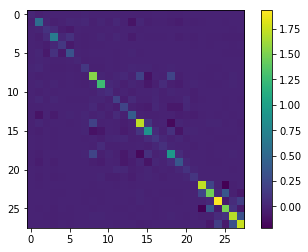

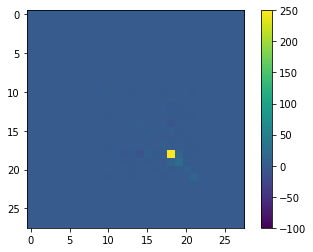

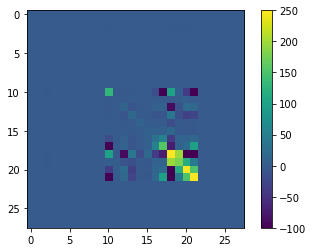

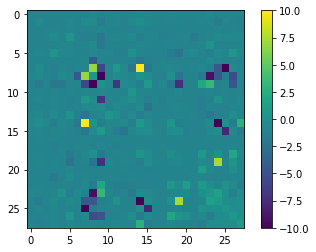

1.973239597917256e-63
3.7058127812371873e-59
1.0436304210160805e-49


In [17]:
#You can safely ignore this... 



(s, logdet) = np.linalg.slogdet(hesssym)
# the real hessian is hesssym multiplied from both sides by diag(1/sigma), or the inverse for the covmat. 
# covmat det picks up prod(sigma)^2; log det picks up 2 sum(sigma). but we need log sqrt(det), so +sum(sigma)
#print(np.diag(hesssym))
#print(logdet)
#print(-np.sum(sigma))
#print(s)


covar = np.linalg.inv(np.diag(1/sigma)@hesssym@np.diag(1/sigma))
plt.imshow(np.linalg.inv(hesssym), interpolation='nearest')
plt.colorbar()
plt.show()
plt.imshow(covar, vmin=-100, vmax=250, interpolation='nearest')
plt.colorbar()
plt.show()
plt.imshow(cov*3, vmin=-100, vmax=250, interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow((covar-cov)/cov, vmin=-10, vmax=10, interpolation='nearest')
plt.colorbar()
plt.show()
print(np.linalg.det(covar))
print(np.linalg.det(cov))
print(np.prod(sigma**2))


In [83]:
off

0.12381031142777932